In [29]:
import numpy as np
import math
from sklearn.preprocessing import normalize
import random
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [30]:
f=open('/Users/weiweili/Documents/UCSD-Stats/CSE 250B Fall16/HW3/wine.data.txt','r')
dat=[line.strip().split(',') for line in f]
dat=np.array(dat)

In [31]:
datp=np.random.permutation(dat)

In [32]:
label=datp[:,0].astype(np.int)
label=label-1

In [33]:
datp = datp[:,1:14].astype(np.float)

In [34]:
offset=np.ones(178)
datp=np.c_[datp,offset]

In [35]:
datm=normalize(datp,axis=0)

In [36]:
dat_train=datm[0:128,]
dat_test=datm[128:178,]
label_train=label[0:128]
label_test=label[128:178]

In [37]:
# make the train_y into 128*3
train_y=np.float32(np.eye(3)[label_train])
train_x=dat_train.transpose()

In [38]:
#gradient matrix 3*14
def gradient(W):
    G=np.zeros((3,14))
    ewx = np.exp(np.dot(W,train_x))
    S=np.sum(ewx,axis=0)
    for i in range(3):
        for j in range(14):
            l = -np.multiply(train_y[:,i],train_x[j,:])
            r = np.multiply(ewx[i,:],train_x[j,:])
            r = np.divide(r,S)
            tmp=l+r
            G[i,j]=np.mean(tmp)
    return(G)   

In [39]:
#loss
def loss(W):
    ewx = np.exp(np.dot(W,train_x))
    S=np.sum(ewx,axis=0)
    tmp=np.log(np.divide(ewx,S)).transpose()
    tmp=-np.multiply(train_y, tmp)
    return np.sum(tmp)/len(train_y)


In [40]:
##error rate
test_x=dat_test.transpose()
def error(W):
    test_y=np.dot(W,test_x)
    K=len(test_y[1,:])
    index=np.zeros(K)

    for k in range(K):
        index[k]=test_y[:,k].argmax()
        
    return 1.0*np.sum(label_test!=index)/len(label_test)


In [41]:
#initial weight matrix 3*14
W0=np.random.normal(0,1,(3,14))

In [42]:
# optimal coordinate descent:
M= 20000
K= 10
alpha = 1e+3
loss_vector=np.zeros(M)
loss_vector[0] = loss(W0)
W_opt = np.copy(W0)
opt_err=np.zeros(M)
opt_err[0]=error(W0)


count=0
for m in range(1,M):  
    ewx = np.exp(np.dot(W_opt,train_x))
    S = np.sum(ewx,axis=0)
    G_matrix = gradient(W_opt)
    for k in range(K):
        pos = np.abs(G_matrix).argmax()
        x = pos/14
        y = pos%14       
        W_opt[x,y] = W_opt[x,y]-alpha*G_matrix[x,y]

    loss_vector[m]=loss(W_opt)
    opt_err[m]=error(W_opt)
    if loss_vector[m]>loss_vector[m-1]:
        count=count+1
    if count>5:
        alpha=alpha/2
        count=0
    if abs(loss_vector[m]-loss_vector[m-1])/loss_vector[m-1] < 1e-4:
        break
M_opt=m
print M_opt, loss_vector[M_opt]



        

6784 0.00247577310898


In [43]:
#random coordinate descent:
randloss_vector=np.zeros(M)
randloss_vector[0] = loss(W0)
W_rand = np.copy(W0)
alpha = 1e+3
rand_err=np.zeros(M)
rand_err[0]=error(W0)

count=0
for m in range(1,M):
    ewx = np.exp(np.dot(W_rand,train_x))
    S=np.sum(ewx,axis=0)
    G_matrix=gradient(W_rand)
    for k in range(K):
        x=random.randint(0,2)
        y=random.randint(0,13)
        W_rand[x,y]=W_rand[x,y]-alpha*G_matrix[x,y]        
    randloss_vector[m]=loss(W_rand)
    rand_err[m]=loss(W_rand)
    if randloss_vector[m]>randloss_vector[m-1]:
        count=count+1
    if count>5:
        alpha=alpha/2
        count=0
    if abs(randloss_vector[m]-randloss_vector[m-1])/randloss_vector[m-1] < 1e-4:
        break
M_rand=m
print M_rand, randloss_vector[M_rand]

       
    

973 0.0722880516908


In [71]:
#final loss 
logreg = linear_model.LogisticRegression(C=float("inf"),multi_class='multinomial',\
                                         solver='lbfgs',\
                                         fit_intercept=False)
logreg.fit(dat_train,label_train)
W_fnl = np.asarray(logreg.coef_)
fnloss=loss(W_fnl)
fnloss

5.0254007252726872e-06

In [59]:
#final error rate 
fnl_err=error(W_fnl)

0.0

Using matplotlib backend: MacOSX


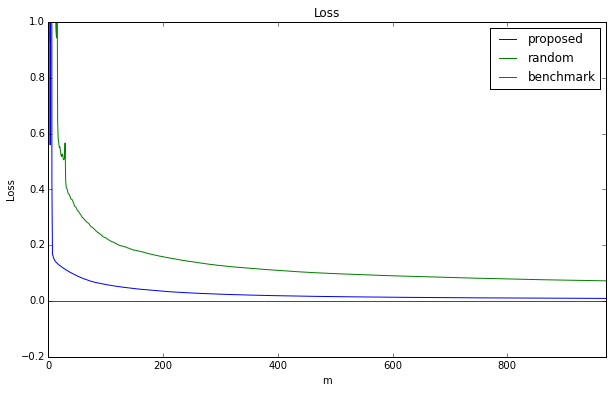

In [69]:
%matplotlib auto
plt.figure(figsize=(10,6))
plt.plot(range(M_opt+1),loss_vector[0:M_opt+1],label='proposed')
plt.plot(range(M_rand+1),randloss_vector[0:M_rand+1],label='random')
plt.axhline(fnloss,color='r',label='benchmark')
plt.xlabel('m')
plt.ylabel('Loss')
plt.title('Loss')
axes = plt.gca()
axes.set_xlim([0,min(M_opt,M_rand)])
axes.set_ylim([-0.2,1])
plt.legend()
plt.show()
plt.savefig('loss.eps', format='eps', dpi=1000)

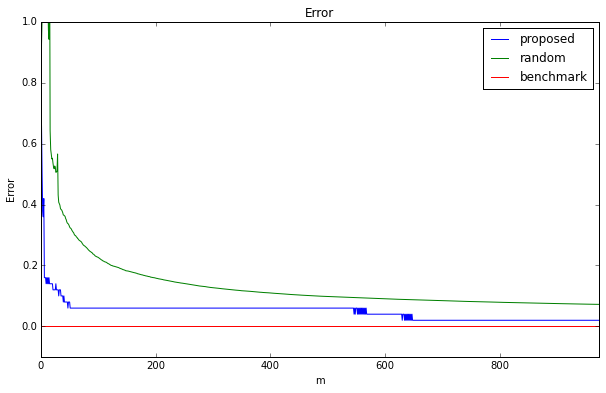

In [70]:
plt.figure(figsize=(10,6))
plt.plot(range(M_opt+1),opt_err[0:M_opt+1],label='proposed')
plt.plot(range(M_rand+1),rand_err[0:M_rand+1],label='random')
plt.axhline(y=fnl_err,color='r',label='benchmark')
plt.xlabel('m')
plt.ylabel('Error')
plt.title('Error')
axes = plt.gca()
axes.set_xlim([0,min(M_opt,M_rand)])
axes.set_ylim([-0.1,1])
plt.legend()
plt.show()
plt.savefig('error.eps', format='eps', dpi=1000)